In [1]:
import os

import pandas as pd
from IPython.display import display

from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARKS_DIR = 'data'
BENCHMARK_NAME = 'Arabidopsis_thaliana_phosphorylation'

# A local (non-global) binary output
OUTPUT_TYPE = OutputType(False, 'binary')
UNIQUE_LABELS = [0, 1]
OUTPUT_SPEC = OutputSpec(OUTPUT_TYPE, UNIQUE_LABELS)


# Loading the dataset

train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % BENCHMARK_NAME)
train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
# train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)
train_set, valid_set = train_test_split(train_set, test_size = 0.1, random_state = 0)


test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % BENCHMARK_NAME)
test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()

print(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')


# Loading the pre-trained model and fine-tuning it on the loaded dataset

pretrained_model_generator, input_encoder = load_pretrained_model()

# get_model_with_hidden_layers_as_outputs gives the model output access to the hidden layers (on top of the output)
model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
        get_model_with_hidden_layers_as_outputs, dropout_rate = 0.5)

training_callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
    keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

finetune(model_generator, input_encoder, OUTPUT_SPEC, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
        seq_len = 512, batch_size = 32, max_epochs_per_stage = 40, lr = 1e-04, begin_with_frozen_pretrained_layers = True, \
        lr_with_frozen_pretrained_layers = 1e-02, n_final_epochs = 1, final_seq_len = 1024, final_lr = 1e-05, callbacks = training_callbacks)


# Evaluating the performance on the test-set

results, confusion_matrix,a,b = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_set['seq'], test_set['label'], \
        start_seq_len = 512, start_batch_size = 32)

column_names = ['label', 'pre']
Pre = pd.DataFrame(list(zip(a, b)), columns=column_names)
Pre.to_csv(f'{BENCHMARKS_DIR}/{BENCHMARK_NAME}.Pre.csv',index=None)

print('Test-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)

2808 training set records, 312 validation set records, 3123 test set records.
[2025_07_23-22:28:28] Training set: Filtered out 0 of 2808 (0.0%) records of lengths exceeding 510.
[2025_07_23-22:28:28] Validation set: Filtered out 0 of 312 (0.0%) records of lengths exceeding 510.
[2025_07_23-22:28:28] Training with frozen pretrained layers...
Epoch 1/40
88/88 [==============================] - 16s 83ms/step - loss: 0.5470 - val_loss: 0.4592
Epoch 2/40
88/88 [==============================] - 5s 57ms/step - loss: 0.4565 - val_loss: 0.5151

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 3/40
88/88 [==============================] - 5s 57ms/step - loss: 0.4235 - val_loss: 0.4409
Epoch 4/40
88/88 [==============================] - 5s 57ms/step - loss: 0.4154 - val_loss: 0.4345
Epoch 5/40
88/88 [==============================] - 5s 57ms/step - loss: 0.4091 - val_loss: 0.4389

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

,# records,AUC
Model seq len,,
512,3123,0.870782
All,3123,0.870782


Confusion matrix:


,0,1
0,1168,394
1,222,1339


DQCSGSGSITSDIKLEGAVTSDIEARDGYVVRGLVNLGNTC 1


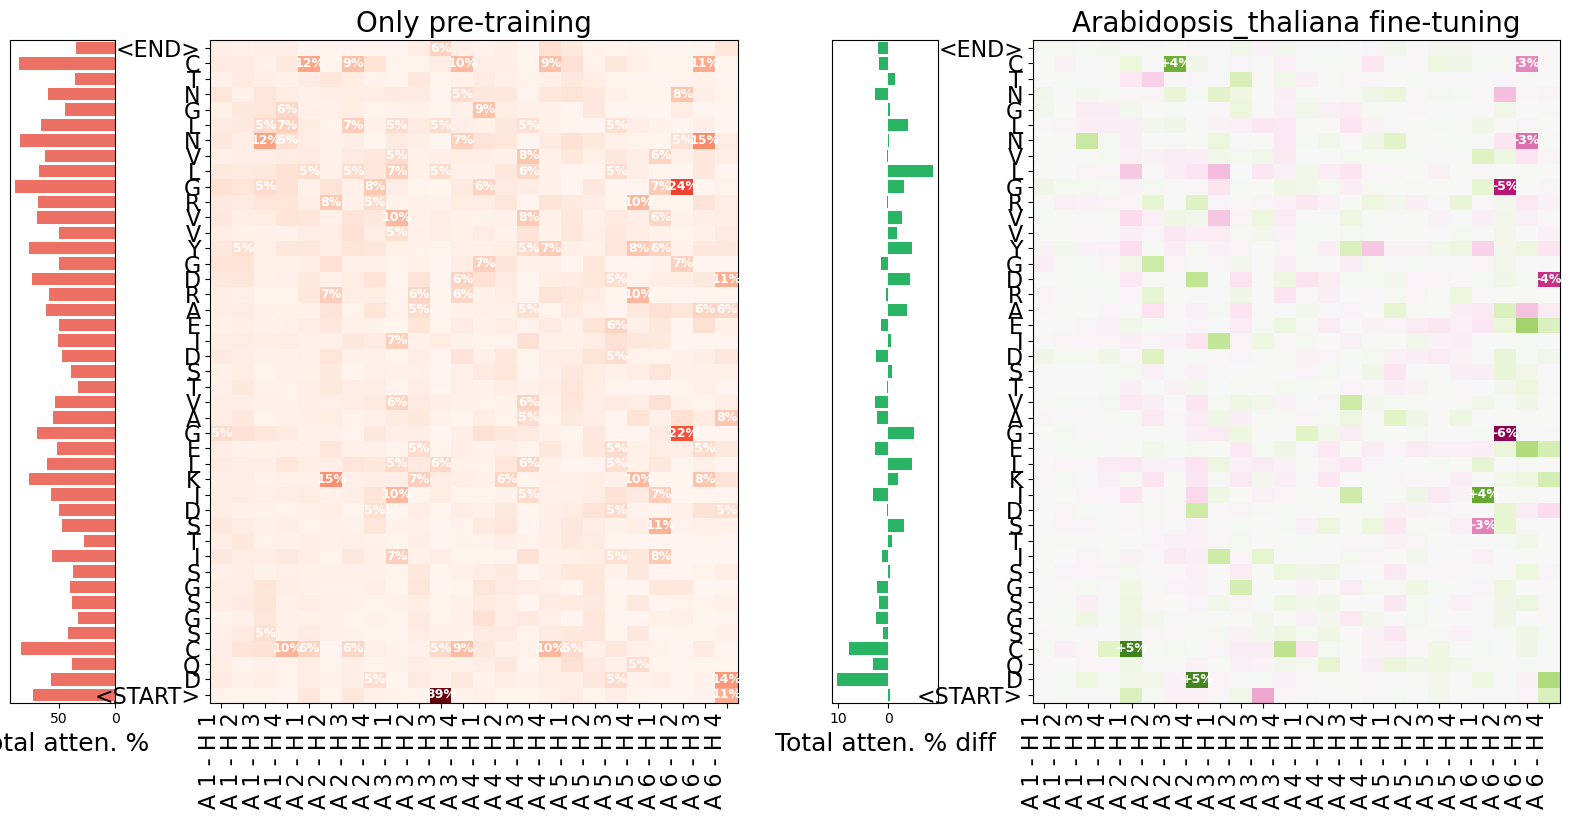

In [10]:
import numpy as np
import matplotlib.pyplot as plt

BENCHMARK_DISPLAY_NAME = 'Arabidopsis_thaliana'

TEST_SET_FILE_PATH = 'data/Arabidopsis_thaliana_phosphorylation.train.csv'
IDEAL_LEN = 51

def calculate_attentions(model, input_encoder, seq, seq_len = None):
    
    from tensorflow.keras import backend as K
    from proteinbert.tokenization import index_to_token
    
    if seq_len is None:
        seq_len = len(seq) + 2
    
    X = input_encoder.encode_X([seq], seq_len)
    (X_seq,), _ = X
    seq_tokens = list(map(index_to_token.get, X_seq))

    model_inputs = [layer.input for layer in model.layers if 'InputLayer' in str(type(layer))][::-1]
    model_attentions = [layer.calculate_attention(layer.input) for layer in model.layers if 'GlobalAttention' in str(type(layer))]
    invoke_model_attentions = K.function(model_inputs, model_attentions)
    attention_values = invoke_model_attentions(X)
    
    attention_labels = []
    merged_attention_values = []

    for attention_layer_index, attention_layer_values in enumerate(attention_values):
        for head_index, head_values in enumerate(attention_layer_values):
            attention_labels.append('A %d - H %d' % (attention_layer_index + 1, head_index + 1))
            merged_attention_values.append(head_values)

    attention_values = np.array(merged_attention_values)
    
    return attention_values, seq_tokens, attention_labels

def plot_attention(attention_values, seq_tokens, attention_labels, ax, cmap = 'Reds', vmin = 0, vmax = None, text_value_threshold = 0.1):

    heatmap = ax.pcolor(attention_values.transpose(), cmap = cmap, vmin = vmin, vmax = vmax)

    ax.set_xticks(np.arange(len(attention_labels)) + 0.5)
    ax.set_xticklabels(attention_labels, rotation = 90, ha = 'right', fontsize = 16)
    ax.set_yticks(np.arange(len(seq_tokens)) + 0.5)
    ax.set_yticklabels(seq_tokens, fontsize = 16)

    for i, row in enumerate(attention_values):
        for j, value in enumerate(row):
            if abs(value) >= text_value_threshold:
                add_plus_sign = attention_values.min() < 0 and value > 0
                plus_sign = '+' if add_plus_sign else ''
                ax.text(i + 0.5, j + 0.5, plus_sign + '%d%%' % (100 * value), color = 'white', ha = 'center', va = 'center', \
                        fontsize = 9, fontweight = 'bold', fontstretch = 'condensed')
                
test_set = pd.read_csv(TEST_SET_FILE_PATH)
chosen_index = ((test_set['seq'].str.len() - IDEAL_LEN).abs()).sort_values().index[0]
seq = test_set.loc[chosen_index, 'seq']
label = test_set.loc[chosen_index, 'label']
                
seq_len = len(seq) + 2

pretrained_model_generator, input_encoder = load_pretrained_model()
model = pretrained_model_generator.create_model(seq_len)
pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)

model = model_generator.create_model(seq_len)
finetuned_attention_values, finetuned_seq_tokens, finetuned_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)
assert finetuned_seq_tokens == pretrained_seq_tokens
assert finetuned_attention_labels == pretrained_attention_labels[:len(finetuned_attention_labels)]

fig, axes = plt.subplots(ncols = 4, figsize = (20, 0.2 * seq_len), gridspec_kw = dict(width_ratios = [1, 5, 1, 5]))
fig.subplots_adjust(wspace = 0.3)

axes[0].barh(np.arange(seq_len), 100 * pretrained_attention_values.sum(axis = 0), color = '#EC7063')
axes[0].set_ylim((-0.5, seq_len - 0.5))
axes[0].set_yticks([])
axes[0].invert_xaxis()
axes[0].set_xlabel('Total atten. %', fontsize = 18)

vmax = pretrained_attention_values.max()
plot_attention(pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels, axes[1], cmap = 'Reds', vmax = vmax, \
        text_value_threshold = 0.05)
axes[1].set_title('Only pre-training', fontsize = 20)

axes[2].barh(np.arange(seq_len), 100 * (finetuned_attention_values - pretrained_attention_values).sum(axis = 0), color = '#28B463')
axes[2].set_ylim((-0.5, seq_len - 0.5))
axes[2].set_yticks([])
axes[2].invert_xaxis()
axes[2].set_xlabel('Total atten. % diff', fontsize = 18)

attention_diff = finetuned_attention_values - pretrained_attention_values[:len(finetuned_attention_labels), :]
vmax = np.abs(attention_diff).max()
plot_attention(attention_diff, finetuned_seq_tokens, finetuned_attention_labels, axes[3], cmap = 'PiYG', vmin = -vmax, vmax = vmax, \
        text_value_threshold = 0.03)
axes[3].set_title('%s fine-tuning' % BENCHMARK_DISPLAY_NAME, fontsize = 20)
#plt.savefig('protein_bert_Arabidopsis_thaliana_phosphorylation.svg', bbox_inches='tight', format='svg')
print(seq, label)

In [3]:
model.save_weights('Arabidopsis_thaliana_phosphorylation.h5')